In [ ]:
pip install pydub

In [ ]:
import tensorflow_datasets as tfds
import tensorflow as tf
from tensorflow.keras.layers.experimental import preprocessing
from IPython import display
from tensorflow.keras import layers
from tensorflow.keras import models

In [ ]:
train = tfds.load('spoken_digit',as_supervised=True, split=tfds.core.ReadInstruction(
    'train', to=60, unit='%'))

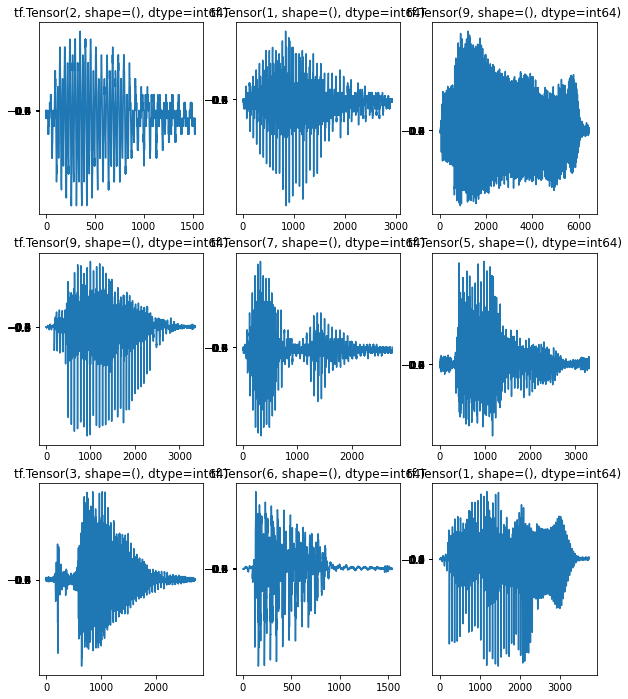

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 12))
for i, (audio, label) in enumerate(train.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  ax.plot(audio.numpy())
  ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
  ax.set_title(str(label))

In [ ]:
def get_spectrogram(waveform):
  # Padding for files with less than 16000 samples
  zero_padding = tf.zeros([8000] - tf.shape(waveform), dtype=tf.float32)

  # Concatenate audio with padding so that all audio clips will be of the 
  # same length
  waveform = tf.cast(waveform, tf.float32)
  equal_length = tf.concat([waveform, zero_padding], 0)
  spectrogram = tf.signal.stft(
      equal_length, frame_length=255, frame_step=128)

  spectrogram = tf.abs(spectrogram)

  return spectrogram

In [ ]:
for waveform, label in train.take(1):
  spectrogram = get_spectrogram(waveform)

print('Label:', label.numpy())
print('Waveform shape:', waveform.shape)
print('Spectrogram shape:', spectrogram.shape)
print('Audio playback')
display.display(display.Audio(waveform, rate=8000))

Label: 2
Waveform shape: (1525,)
Spectrogram shape: (61, 129)
Audio playback


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.


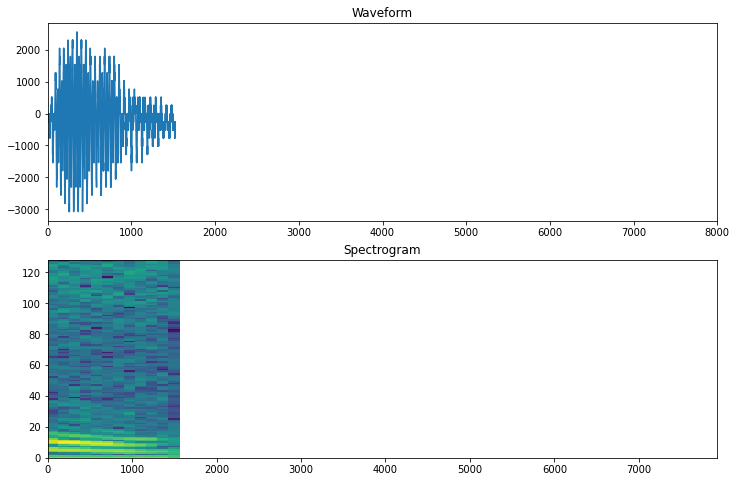

In [ ]:
def plot_spectrogram(spectrogram, ax):
  # Convert to frequencies to log scale and transpose so that the time is
  # represented in the x-axis (columns).
  log_spec = np.log(spectrogram.T)
  height = log_spec.shape[0]
  X = np.arange(8000, step=height + 1)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)


fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 8000])
plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.show()

In [ ]:
labels = [0,1,2,3,4,5,6,7,8,9]
def get_spectrogram_and_label_id(audio, label):
  spectrogram = get_spectrogram(audio)
  spectrogram = tf.expand_dims(spectrogram, -1)
  label_id = tf.argmax(label == labels)
  return spectrogram, label_id

In [ ]:
spectrogram_ds = train.map(get_spectrogram_and_label_id, num_parallel_calls= tf.data.AUTOTUNE)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.


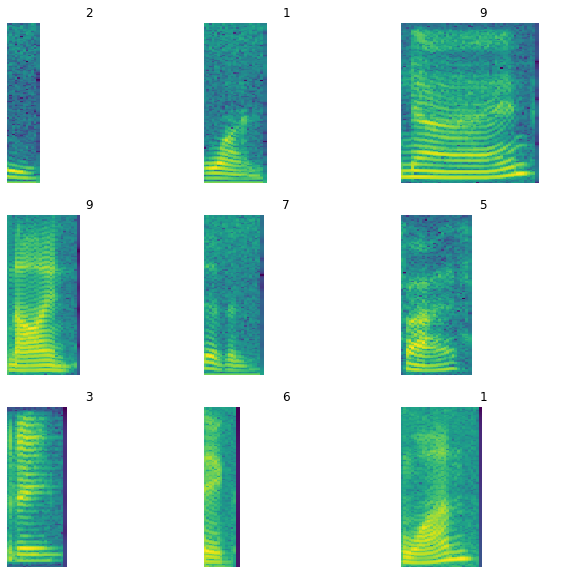

In [ ]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 10))
for i, (spectrogram, label_id) in enumerate(spectrogram_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  plot_spectrogram(np.squeeze(spectrogram.numpy()), ax)
  ax.set_title(labels[label_id.numpy()])
  ax.axis('off')

plt.show()

In [ ]:
batch_size = 64
train_ds = spectrogram_ds.batch(batch_size)

In [ ]:
train_ds = train_ds.cache().prefetch(tf.data.AUTOTUNE)

In [ ]:
for spectrogram, _ in spectrogram_ds.take(1):
  input_shape = spectrogram.shape
print('Input shape:', input_shape)
num_labels = len(labels)

norm_layer = preprocessing.Normalization()
norm_layer.adapt(spectrogram_ds.map(lambda x, _: x))

model = models.Sequential([
    layers.Input(shape=input_shape),
    preprocessing.Resizing(32, 32), 
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [ ]:
EPOCHS = 10
history = model.fit(
    train_ds, 
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/10
24/24 [==============================] - 6s 235ms/step - loss: 2.0764 - accuracy: 0.2428


Epoch 2/10
24/24 [==============================] - 4s 175ms/step - loss: 1.4198 - accuracy: 0.5232


Epoch 3/10
24/24 [==============================] - 4s 176ms/step - loss: 1.1082 - accuracy: 0.6260


Epoch 4/10
24/24 [==============================] - 4s 177ms/step - loss: 0.8474 - accuracy: 0.7285


Epoch 5/10
24/24 [==============================] - 4s 176ms/step - loss: 0.7234 - accuracy: 0.7824


Epoch 6/10
24/24 [==============================] - 4s 176ms/step - loss: 0.5739 - accuracy: 0.8277


Epoch 7/10
24/24 [==============================] - 4s 177ms/step - loss: 0.4727 - accuracy: 0.8506


Epoch 8/10
24/24 [==============================] - 4s 178ms/step - loss: 0.4281 - accuracy: 0.8627


Epoch 9/10
24/24 [==============================] - 4s 181ms/step - loss: 0.3783 - accuracy: 0.8876


Epoch 10/10
24/24 [==============================] - 4s 181ms/step - loss: 0.3214 - accuracy: 0.9006


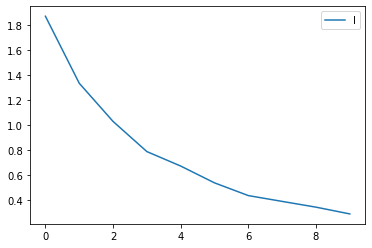

In [ ]:
metrics = history.history
plt.plot(history.epoch, metrics['loss'])
plt.legend('loss')
plt.show()

In [ ]:
test = tfds.load('spoken_digit',as_supervised=True, split=tfds.core.ReadInstruction(
    'train', from_=60, to=62, unit='%'))

In [ ]:
test = test.map(get_spectrogram_and_label_id, num_parallel_calls= tf.data.AUTOTUNE)

In [ ]:
test_audio = []
test_labels = []

for audio, label in test:
  test_audio.append(audio.numpy())
  test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)

In [ ]:
y_pred = np.argmax(model.predict(test_audio), axis=1)
y_true = test_labels

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.0%}')

Test set accuracy: 94%


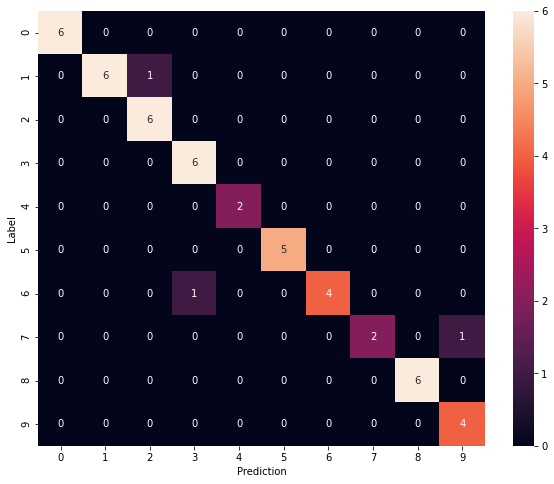

In [ ]:
import seaborn as sns
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred) 
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, xticklabels=labels, yticklabels=labels, 
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()